# mAP for phenotypic consistency assesement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copairs import map

## Introduction

This example demostrates how to use `copairs` to assess phenotypic consistncy of perturbations htat target the same gene against other perturbations.

Phenotypic consistency is assessed by calculating mean average precision (mAP) for the retrieval of phenotypically active samples that share expected biological similarity (such as chemical mechanisms of action and gene-gene relationships) against other phenotypically active samples that are not biologically similar to the query sample.

It aims to answer the question: “How distinctive is this group of perturbations from other phenotypically active samples that are not biologically similar to the query sample?”

The resulting mAP score for a group of perturbations reflects the average extent to which members of this group are more similar to each other compared to other groups (see Figure 1F).

Citation:
> Kalinin, A. A. et al. A versatile information retrieval framework for evaluating profile strength and similarity. bioRxiv, 2024-04, (2024).

## Load data

Assessing phenotypic consistency relies on data and results from the [Phenotypic activity](./phenotypic_activity.ipynb) example, so run that one first if you haven't.

In [2]:
df = pd.read_csv("data/2016_04_01_a549_48hr_batch1_plateSQ00014812.csv")
activity_map = pd.read_csv(
    "data/activity_map.csv"
)  # load mAP scores for phenotypic activity

## Assessing phenotypic consistency of compounds grouped by targets

First, we are going to filter out compounds that were not phenotypically active using mAP p-values from the previous section.

Next, we will aggregate each compound’s replicate profiles into a "consensus" profile by taking the median of each feature to reduce profile noise and improve computational efficiency.

In [3]:
# only keep active compounds, i.e. those with corrected p-value < 0.05
active_compounds = activity_map.query("below_corrected_p")["Metadata_broad_sample"]
df_active = df.query("Metadata_broad_sample in @active_compounds")
df_active.head(7)

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_pert_id_vendor,Metadata_cell_id,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
6,C-7161-01-LM6-022,BRD-K74363950-004-01-0,5.655600,10.000000,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A07,NaN,A549,...,-0.51038,-0.76402,1.616400,-0.49600,-0.481360,2.421100,1.10790,1.13820,1.14320,0.329230
7,C-7161-01-LM6-022,BRD-K74363950-004-01-0,1.885200,3.333300,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A08,NaN,A549,...,-0.23602,-0.41129,0.304960,0.47884,0.005852,-0.710330,0.41986,-0.23888,0.54949,-0.092826
8,C-7161-01-LM6-022,BRD-K74363950-004-01-0,0.628400,1.111100,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A09,NaN,A549,...,-0.52939,-0.54727,0.722570,0.73399,0.223850,0.035842,0.33318,0.39064,0.42969,-0.811390
9,C-7161-01-LM6-022,BRD-K74363950-004-01-0,0.209470,0.370370,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A10,NaN,A549,...,-0.58515,-0.41533,0.044874,0.76374,0.062913,-0.656850,0.18149,-0.10960,0.48699,-0.345260
10,C-7161-01-LM6-022,BRD-K74363950-004-01-0,0.069823,0.123460,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A11,NaN,A549,...,-0.52686,-0.57823,0.591610,0.85184,0.560370,0.039184,0.59864,0.44123,0.75783,-0.018031
11,C-7161-01-LM6-022,BRD-K74363950-004-01-0,0.023274,0.041152,DMSO,BRD-K74363950,BRD-K74363950-004-01-0,A12,NaN,A549,...,-0.48060,-1.47220,0.814150,0.79463,0.089249,0.072240,0.91828,0.39626,1.09120,-0.243750
12,C-7161-01-LM6-022,BRD-K75958547-238-01-0,4.615400,10.000000,DMSO,BRD-K75958547,BRD-K75958547-238-01-0,A13,NaN,A549,...,-5.89680,-0.97404,-5.025000,-10.41400,-6.067500,7.625700,3.31830,3.27410,-2.12240,2.299300


In [4]:
# aggregate replicates by taking the median of each feature
feature_cols = [c for c in df_active.columns if not c.startswith("Metadata")]
df_active = df_active.groupby(
    ["Metadata_broad_sample", "Metadata_target"], as_index=False
)[feature_cols].median()
df_active["Metadata_target"] = df_active["Metadata_target"].str.split("|")
df_active.head()

,Metadata_broad_sample,Metadata_target,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_InverseDifferenceMoment_AGP_5_0,Nuclei_Texture_InverseDifferenceMoment_DNA_20_0,Nuclei_Texture_InverseDifferenceMoment_ER_5_0,Nuclei_Texture_InverseDifferenceMoment_Mito_10_0,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_Variance_RNA_10_0
0,BRD-A69636825-003-04-7,"[CACNA1C, CACNA1S, CACNA2D1, CACNG1, HTR3A, KC...",-0.326365,0.651610,0.211280,0.092412,0.456915,0.486515,0.435545,0.863160,...,0.175200,0.557360,-0.859465,0.409045,0.201909,-1.003185,-1.405850,-1.495100,-0.867225,-0.066115
1,BRD-A69815203-001-07-6,"[ABCB11, CAMLG, FPR1, PPIA, PPIF, PPP3CA, PPP3...",2.487450,-2.872750,0.616635,-0.451942,-2.260100,-3.300900,0.316320,-1.825400,...,-2.681800,-0.197230,-4.717350,0.644170,1.324100,0.103070,0.986025,1.346200,0.773450,-2.749350
2,BRD-A70858459-001-01-7,"[ESR1, ESR2, MAP1A, MAP2]",-0.920210,1.461550,0.445630,-0.394235,1.528450,1.116100,-0.054990,1.061270,...,0.238875,0.326475,0.064563,0.187646,0.200447,-0.695660,0.100225,0.401885,0.114583,-0.245753
3,BRD-A72309220-001-04-1,"[HTR1A, HTR1B, HTR1D, HTR1E, HTR1F, HTR2A, HTR...",0.045435,0.099755,0.103628,0.592620,-0.352200,0.202930,-0.059855,-0.353755,...,1.069575,-0.475915,-0.174002,0.217965,0.090715,-0.154695,0.165235,-0.160191,0.242195,-0.126886
4,BRD-A73368467-003-17-6,[HRH1],-0.062074,-0.314820,0.526190,-0.502485,-0.444675,-0.191225,0.145019,0.018870,...,0.527805,-1.204250,0.615420,-0.187645,0.321880,1.013235,0.793675,0.682925,1.075500,0.844115


Now, we again use metadata columns to define grouping of profiles. Here, we'd like to group those compounds that share a target and assess their similarity against compounds that do not have the same target:

* Two compound profiles are a positive pair if they share the same target. To define that using metadata columns, positive pairs should share the same value in the metadata column that identifies targets (`Metadata_target`). We add this column to a list names `pos_sameby`.

* In this case, profiles that form a positive pair do not need to be different in any of the metatada columns, so we keep `pos_diffby` empty. Although one could define them as being structurally different, for example.

* Two profiles are a negative pair when do not share a common target. That means they should be different in the metadata column that identifies targets (`Metadata_target`).

* Profiles that form a negative pair do not need to be same in any of the metatada columns, so we keep `neg_sameby` empty.

We use `map.multilabel.average_precision` because each compound can have more than one target. If that's not the case, the standard `map.average_precision` should be used instead.

In [5]:
# positive pairs are compounds that share a target
pos_sameby = ["Metadata_target"]
pos_diffby = []

neg_sameby = []
# negative pairs are compounds that do not share a target
neg_diffby = ["Metadata_target"]

metadata = df_active.filter(regex="^Metadata")
profiles = df_active.filter(regex="^(?!Metadata)").values

target_aps = map.multilabel.average_precision(
    metadata,
    profiles,
    pos_sameby=pos_sameby,
    pos_diffby=pos_diffby,
    neg_sameby=neg_sameby,
    neg_diffby=neg_diffby,
    multilabel_col="Metadata_target",
)
target_aps

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,Metadata_broad_sample,average_precision,n_pos_pairs,n_total_pairs,Metadata_target
52,BRD-A69636825-003-04-7,0.500000,1,42,HTR3A
32,BRD-A72309220-001-04-1,0.406071,4,42,HTR1A
37,BRD-A72309220-001-04-1,0.142857,1,39,HTR1B
39,BRD-A72309220-001-04-1,0.142857,1,39,HTR1D
41,BRD-A72309220-001-04-1,0.142857,1,39,HTR1E
...,...,...,...,...,...
16,BRD-K74363950-004-01-0,0.105128,2,42,CHRM3
19,BRD-K74363950-004-01-0,0.105128,2,42,CHRM4
22,BRD-K74363950-004-01-0,0.105128,2,42,CHRM5
28,BRD-K76908866-001-07-6,0.500000,1,42,ERBB2


Then, we can compute mAP scores and p-values for each target group.

In [6]:
target_maps = map.mean_average_precision(
    target_aps, pos_sameby, null_size=1000000, threshold=0.05, seed=0
)
target_maps["-log10(p-value)"] = -target_maps["corrected_p_value"].apply(np.log10)
target_maps.head(10)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

,Metadata_target,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
0,ADRA1A,0.250000,0.112414,0.186114,False,False,0.730220
1,ADRA2A,0.250000,0.112414,0.186114,False,False,0.730220
2,AURKA,0.625000,0.023976,0.103896,True,False,0.983402
3,BIRC2,0.060662,0.380492,0.471085,False,False,0.326901
4,CHRM1,0.098420,0.492938,0.492938,False,False,0.307208
5,CHRM2,0.098420,0.492938,0.492938,False,False,0.307208
6,CHRM3,0.098420,0.492938,0.492938,False,False,0.307208
7,CHRM4,0.098420,0.492938,0.492938,False,False,0.307208
8,CHRM5,0.098420,0.492938,0.492938,False,False,0.307208
9,DRD2,0.750000,0.000670,0.004355,True,True,2.361012


Similarly, we can plot the results, where groups of compounds targeting the same gene are called consistent if their corrected p-value < 0.05.

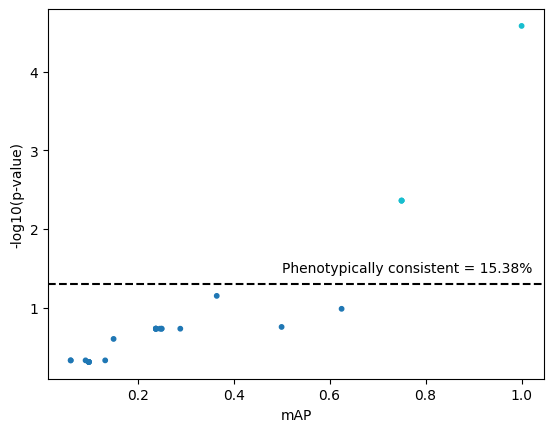

In [7]:
consistent_ratio = target_maps.below_corrected_p.mean()

plt.scatter(
    data=target_maps,
    x="mean_average_precision",
    y="-log10(p-value)",
    c="below_corrected_p",
    cmap="tab10",
    s=10,
)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(
    0.5,
    1.5,
    f"Phenotypically consistent = {100 * consistent_ratio:.2f}%",
    va="center",
    ha="left",
)

plt.show()

Now we can list compounds that are phenotypically active and consistent.

Note that in multi-label scenario, when each compound can have multiple targets, the same compound can have "consistent" response in respect to one target, but not another.

In [8]:
consistent_targets = target_maps.query("below_corrected_p")["Metadata_target"]
consistent_compounds = df_active[
    df_active["Metadata_target"].apply(
        lambda x: any(t in x for t in consistent_targets)
    )
]["Metadata_broad_sample"]

print(f"Phenotypically consistent targets: {consistent_targets.str.cat(sep=', ')}")
print(f"Phenotypically consistent compounds: {consistent_compounds.str.cat(sep=', ')}")

Phenotypically consistent targets: DRD2, EGFR, HTR3A, PSMB1
Phenotypically consistent compounds: BRD-A69636825-003-04-7, BRD-K50691590-001-02-2, BRD-K60230970-001-10-0, BRD-K70330367-003-07-9, BRD-K70358946-001-15-7, BRD-K70401845-003-09-6, BRD-K70914287-300-02-8
